# Occultation Class

The `Occultation` Class within SORA was created to reduce and analyze stellar occultations, and manage all the other Objects in a SORA occultation. Here we have some useful tasks that allow converting the times for each observatory in positions in the sky plane ($\xi$, $\eta$), fit an ellipse to the points, obtain the astrometrical position resulting, among others.

The documentation <a href=https://sora.readthedocs.io/>here</a> contains the details about every step.  

This Jupyter-Notebook was designed as a tutorial for how to work with the `Occultation` Class. More information about the other classes, please refer to their specif Jupyter-Notebook. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.

**The** `Occultation` **Docstring was designed to help the users. Also, each function has its Docstring containing its main purpose and the needed parameters (physical description and formats). Please, do not hesitate to use it.**

## 0. Index

1. [Instantiating an Occultation Object and adding observations](#section_1)

2. [Projecting the times in the sky plane and the Chords](#section_2)

3. [Ellipse fit](#section_3)

4. [Viewing and saving the results](#section_4)

In [1]:
## SORA package
from sora import Occultation, Body, Star, LightCurve, Observer

## Other main packages
#from astropy.time import Time
import astropy.units as u

## Usual packages
import numpy as np
import matplotlib.pylab as pl
import os

SORA version: 0.2dev


<a id="section_1"></a>

## 1. Instantiating an Occultation Object and adding observations

The `Occultation` Class can be instantiated in only one way. For this it is needed a `Star` Object, an `Body` Object with an `Ephemeris` Object (`EphemKernel`, `EphemPlanet` or `EphemHorizons`), and the occultation time (within 60 minutes of the correct value).

In [2]:
Occultation?

Init signature:
Occultation(
    star,
    body=None,
    ephem=None,
    time=None,
    reference_center='geocenter',
)
Docstring:     
Instantiates the Occultation object and performs the reduction of the
occultation.

Attributes
----------
star : `sora.Star`, `str`, required
    the coordinate of the star in the same reference frame as the ephemeris.
    It must be a Star object or a string with the coordinates of the object
    to search on Vizier.

body : `sora.Body`, `str`
    Object that will occult the star. It must be a Body object or its name
    to search in the Small Body Database.

ephem : `sora.Ephem`, `list`
    Object ephemeris. It must be an Ephemeris object or a list.

time : `str`, `astropy.time.Time`, required
    Reference time of the occultation. Time does not need to be exact, but
    needs to be within approximately 50 minutes of the occultation closest
    approach to calculate occultation parameters.

reference_center : `str`, `sora.Observer`, `sora.Spacecraft

**First let's instantiate the `Star` and the `Body`**

SORA will automatically search for the star information. A warning will raise when any information is missing. In this example, there is no star radius available in Gaia.

In [3]:
chariklo = Body(name='Chariklo', 
                ephem=['input/bsp/Chariklo.bsp', 'input/bsp/de438_small.bsp'])

star_occ  = Star(coord='18 55 15.65250 -31 31 21.67051') # Occ Chariklo 22-06-2017

Obtaining data for Chariklo from SBDB

1 Gaia-EDR3 star found G=14.223702
star coordinate at J2016.0: RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.018 mas



**Now, we can instantiate the** `Occultation`

In [4]:
occ = Occultation(star=star_occ, body=chariklo, time='2017-06-22 21:18')

print(occ)

Stellar occultation of star Gaia-EDR3 6760223758801661440 by 10199 Chariklo (1997 CU26).

Geocentric Closest Approach: 0.049 arcsec
Instant of CA: 2017-06-22 21:18:48.200
Position Angle: 359.72 deg
Geocentric shadow velocity: 22.00 km / s
Sun-Geocenter-Target angle:  166.42 deg
Moon-Geocenter-Target angle: 149.11 deg


No observations reported

###############################################################################
                                     STAR                                      
###############################################################################
Gaia-EDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=0.00 +/- 0.00 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H: 11.781,
            K: 11.627

Apparent diameter from Kervella et. al (2004):

If the occultation was observed by a spacecraft, the Occultation parameters should be refered to this observer. For that, it is necessary to pass the observer as the center of reference for the `Occultation`

In [5]:
# from sora import Spacecraft
# nh = Spacecraft(name='New Horizons', spkid='-98', ephem='horizons')
# nh_occ = Occultation(star=star, body=body, time=time, reference_center=nh)

**Note that at the** `print(Occultation)` **there are no observations added to this** `Occultation` **yet.**

It is needed one `Observer` and one `LightCurve` to define an `Chord`.

**Let's instanciate the** `Observers`

Here we will give 5 locations

In [6]:
out = Observer(name='Outeniqua'  ,lon='+16 49 17.710', lat='-21 17 58.170', height =1416)
ond = Observer(name='Onduruquea' ,lon='+15 59 33.750', lat='-21 36 26.040', height =1220)
tiv = Observer(name='Tivoli'     ,lon='+18 01 01.240', lat='-23 27 40.190', height =1344)
whc = Observer(name='Windhoek'   ,lon='+17 06 31.900', lat='-22 41 55.160', height =1902)
hak = Observer(name='Hakos'      ,lon='+16 21 41.320', lat='-23 14 11.040', height =1843)

If a spacecraft observed the occultation, a `Spacecraft` object could be defined and added to the `Occultation` normally.

**Let's instanciate the** `LightCurves`

Here we give 6 light curves. Note that 2 are for the same site observed with different telescopes.

In [7]:
#INCREASE THE ERRORS!!!!

out_lc = LightCurve(name='Outeniqua lc',
                    initial_time='2017-06-22 21:20:00.056',
                    end_time ='2017-06-22 21:29:59.963',
                    immersion='2017-06-22 21:21:20.329',immersion_err=0.320,
                    emersion ='2017-06-22 21:21:30.343',emersion_err=0.340)

ond_lc = LightCurve(name='Onduruquea lc',
                    initial_time='2017-06-22 21:11:52.175',
                    end_time ='2017-06-22 21:25:13.389',
                    immersion='2017-06-22 21:21:22.213',immersion_err=0.100,
                    emersion ='2017-06-22 21:21:33.824',emersion_err=0.110)

tiv_lc = LightCurve(name='Tivoli lc',
                    initial_time='2017-06-22 21:16:00.094',
                    end_time ='2017-06-22 21:28:00.018',
                    immersion='2017-06-22 21:21:15.628',immersion_err=0.700,
                    emersion ='2017-06-22 21:21:19.988',emersion_err=0.700)

whc_c14_lc = LightCurve(name='Windhoek C14 lc',
                    initial_time='2017-06-22 21:12:48.250',
                    end_time ='2017-06-22 21:32:47.963',
                    immersion='2017-06-22 21:21:17.609',immersion_err=0.240,
                    emersion ='2017-06-22 21:21:27.564',emersion_err=0.260)

whc_d16_lc = LightCurve(name='Windhoek D16 lc',
                    initial_time='2017-06-22 21:20:01.884',
                    end_time ='2017-06-22 21:22:21.894',
                    immersion='2017-06-22 21:21:17.288',immersion_err=0.280,
                    emersion ='2017-06-22 21:21:27.228',emersion_err=0.340)

hak_lc = LightCurve(name='Hakos lc',
                    initial_time='2017-06-22 21:10:19.461',
                    end_time ='2017-06-22 21:30:19.345')

**To add the observation to the** `Occultation` **just use the** `Occultation.chords.add_chord()`

During this step the `LightCurve` model parameters are automaticaly updated using the `Occultation` parameters: the Shadow's velocity, the star diameter and the distance to the occulting body. This means that is no need for the user to do the `LightCurve.set_dist()`, `LightCurve.set_vel()` and `LightCurve.set_star_diam()`.

In [8]:
occ.chords.add_chord(observer=out, lightcurve=out_lc)
occ.chords.add_chord(observer=ond, lightcurve=ond_lc)
occ.chords.add_chord(observer=tiv, lightcurve=tiv_lc)

/home/morgado/anaconda3/lib/python3.8/site-packages/sora/body/core.py:292: UserWarning: H and/or G is not defined for 10199 Chariklo. Searching into JPL Horizons service
  warnings.warn('H and/or G is not defined for {}. Searching into JPL Horizons service'.format(self.shortname))


<Chord: Tivoli>

Note that a warning comes up if the flux drop is not calculated automatically.

**The same goes for two observation at with the same** `Observer` **, however is important to define their names as different values**

In [9]:
occ.chords.add_chord(name='Windhoek C14', observer=whc, lightcurve=whc_c14_lc)
occ.chords.add_chord(name='Windhoek D16', observer=whc, lightcurve=whc_d16_lc)

<Chord: Windhoek D16>

**Also, the same goes for negative observations**

In [10]:
occ.chords.add_chord(observer=hak, lightcurve=hak_lc)

<Chord: Hakos>

If an spacecraft observed the occultation, just define the `Spacecraft` object and add it to the `Occutation` as usual.

In [11]:
# from sora import Spacecraft
# nh = Spacecraft(name='New Horizons', spkid='-98', ephem='horizons')
# occ.chords.add_chord(observer=nh, lightcurve=lightcurve)

**To check which observers were added to the** `Occultation` **just use** `Occultation.chords`

In [12]:
occ.chords

<ChordList:
    0: Chord(Outeniqua)
    1: Chord(Onduruquea)
    2: Chord(Tivoli)
    3: Chord(Windhoek C14)
    4: Chord(Windhoek D16)
    5: Chord(Hakos)>

**If any of them was wrongly added just remove it using** `Occultation.chords.remove_chord()`

In [13]:
occ.chords.remove_chord(name='Outeniqua')

In [14]:
occ.chords

<ChordList:
    0: Chord(Onduruquea)
    1: Chord(Tivoli)
    2: Chord(Windhoek C14)
    3: Chord(Windhoek D16)
    4: Chord(Hakos)>

**If all the chords were wrongly added the user can clear the** `Occultation` **using** `Occultation.chords.clear()`

In [15]:
occ.chords.clear()

In [16]:
occ.chords

<ChordList:>

In [17]:
occ.chords.add_chord(observer=out, lightcurve=out_lc)
occ.chords.add_chord(observer=ond, lightcurve=ond_lc)
occ.chords.add_chord(observer=tiv, lightcurve=tiv_lc)
occ.chords.add_chord(name='Windhoek C14', observer=whc, lightcurve=whc_c14_lc)
occ.chords.add_chord(name='Windhoek D16', observer=whc, lightcurve=whc_d16_lc)
occ.chords.add_chord(observer=hak, lightcurve=hak_lc)

<Chord: Hakos>

<a id="section_2"></a>

## 2. Projecting the times in the sky plane and the Chords

This step is done automatically without the user having to ask for it. The user can see it automatically using `Occultation.chords.summary()` that contains all positions for all observations added.

In [18]:
occ.chords.summary()

    Name      Longitude      Latitude      status              time              f        g   
------------ ------------ ------------- ------------ ----------------------- --------- -------
   Outeniqua 16d49m17.71s -21d17m58.17s Initial Time 2017-06-22 21:20:00.056  -1912.82   45.76
                                           Immersion 2017-06-22 21:21:20.329   -118.28   65.39
                                            Emersion 2017-06-22 21:21:30.343    105.60   67.83
                                            End Time 2017-06-22 21:29:59.963  11501.40  190.23
  Onduruquea 15d59m33.75s -21d36m26.04s Initial Time 2017-06-22 21:11:52.175 -12876.38 -135.47
                                           Immersion 2017-06-22 21:21:22.213   -138.25    7.19
                                            Emersion 2017-06-22 21:21:33.824    121.28   10.05
                                            End Time 2017-06-22 21:25:13.389   5029.49   63.76
      Tivoli 18d01m01.24s -23d27m40.19s Initial Ti

**Let's give a look to an specific** `Chord`

In [19]:
chord = occ.chords['Outeniqua']

**The user can easily acess the f and g for the immersion and emersion times using the** `Chord.get_fg()`

In [20]:
chord.get_fg()

(array([-118.2787508 ,  105.59793966]), array([65.39156611, 67.83395615]))

**The user can also set a specific time**

In [21]:
chord.get_fg(time='2017-06-22 21:00:00.000')

(-28724.98453471431, -258.3575388604654)

**Finally, the user can visually see the chord in the Sky-plane using the** `Chord.plot_chord()`.

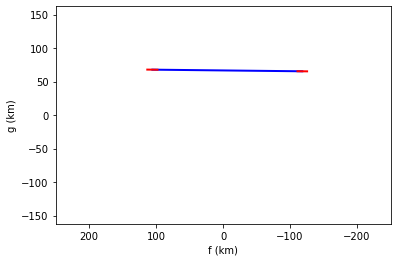

In [22]:
chord.plot_chord(segment='positive', color='blue')
chord.plot_chord(segment='error', color='red')

pl.xlim(+250,-250)
pl.ylim(-250,+250)
pl.show()

**Let's define a** `LightCurve` **with times and fluxes**

In [23]:
chord2 = occ.chords['Hakos']

chord2.lightcurve.set_flux(file='input/lightcurves/lc_example_5.dat', exptime=1.000, usecols=[0,1])

**The** `Chord.plot_chord()` **can also be used with an** `linestyle = "exposure"` **to see the times where the the chord in fact holds information and the readout time (without information).**

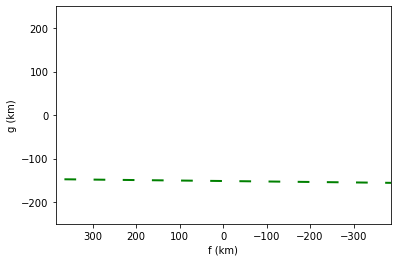

In [24]:
chord2.plot_chord(segment='negative', linestyle='exposure', color='green')

pl.xlim(+250,-250)
pl.ylim(-250,+250)
pl.show()

**Now let's consider all the chords**

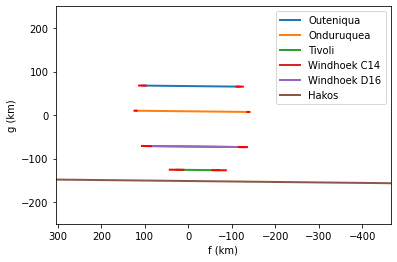

In [25]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**If there are known time shifts, this can be easily solved using** `LightCurve.dt`

In [26]:
out_lc.dt = -0.150
ond_lc.dt = -0.190
tiv_lc.dt = -0.150
whc_c14_lc.dt = -0.375
whc_d16_lc.dt = +0.000

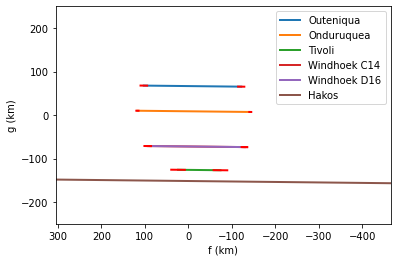

In [27]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**The user can save these positions**

In [28]:
occ.to_file()

<a id="section_3"></a>

## 3. Ellipse fit

The next step is the fitting of an ellipse. The five parameters that describe the ellipse are:

**1.** and **2.** The centre position ($f_0$, $g_0$)

**3.** The apparent equatorial radius, semi-major axix ($a'$)

**4.** The oblatness ($\epsilon' = \frac{a' - b'}{a'}$) 

**5.** The position angle of the pole, semi-minor axis ($P$)

The result of the fit is a `ChiSquare` Object, and its functions can be found at its specific Jupyter-Notebook.

**Here, there is only the manual method, the user should provide the parameters to the fit and also the region for searching each parameters.**

The equation to be minimize is:

$\chi^2 = \sum_{i}^{N} \frac{(r_{i} - r'_{i})^2}{\sigma_i^2 + \sigma_{model}^2}$

where:
- $r_i$ is the radial distance between the $i^{th}$ observed point and the ellipse centre;
- $r'_i$ is the radial distance between the modelled ellipse's $i^{th}$ point and the ellipse centre;
- $\sigma_i$ is the unceartainty of the $i^{th}$ observed point
- $\sigma_{model}$ is the model uncertainty, that is releated to the difference between the real apparent shape of the occultating object and the ellipse model.

In [29]:
occ.fit_ellipse?

Signature: occ.fit_ellipse(**kwargs)
Docstring:
Fits an ellipse to given occultation using given parameters.

Parameters
----------
center_f : `int`, `float`, default=0
    The coordinate in f of the ellipse center.

center_g : `int`, `float`, default=0
    The coordinate in g of the ellipse center.

equatorial_radius : `int`, `float`
    The Equatorial radius (semi-major axis) of the ellipse.

oblateness : `int`, `float`, default=0
    The oblateness of the ellipse.

position_angle : `int`, `float`, default=0
    The pole position angle of the ellipse in degrees.
    Zero is in the North direction ('g-positive'). Positive clockwise.

dcenter_f : `int`, `float`
    Interval for coordinate f of the ellipse center.

dcenter_g : `int`, `float`
    Interval for coordinate g of the ellipse center.

dequatorial_radius `int`, `float`
    Interval for the Equatorial radius (semi-major axis) of the ellipse.

doblateness : `int`, `float`
    Interval for the oblateness of the ellipse

dposition_

In [30]:
ellipse_chi2  = occ.fit_ellipse(center_f=-15.046, center_g=-2.495, dcenter_f=10, dcenter_g=20, 
                                equatorial_radius=138, dequatorial_radius=50, oblateness=0.093, 
                                doblateness=0.20, position_angle=90, dposition_angle=90 ,loop=100000,
                                dchi_min=10,number_chi=20000)

Ellipse fit: |████████████████████████████████████████|  - 100% 


Note that here we only used 100000 loops, but it is recommended at least 10 millions for a good sample for each parameter.

In [31]:
print(ellipse_chi2)

Minimum chi-square: 0.427
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.085

center_f:
    1-sigma: -13.506 +/- 1.250
    3-sigma: -13.516 +/- 4.409

center_g:
    1-sigma: -1.515 +/- 5.842
    3-sigma: 0.322 +/- 17.131

equatorial_radius:
    1-sigma: 140.809 +/- 8.256
    3-sigma: 152.003 +/- 24.663

oblateness:
    1-sigma: 0.091 +/- 0.053
    3-sigma: 0.139 +/- 0.139

position_angle:
    1-sigma: 127.154 +/- 21.627
    3-sigma: 90.005 +/- 89.993



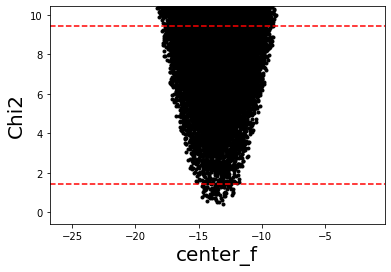

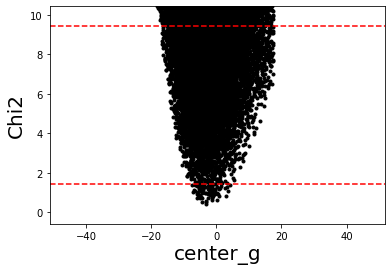

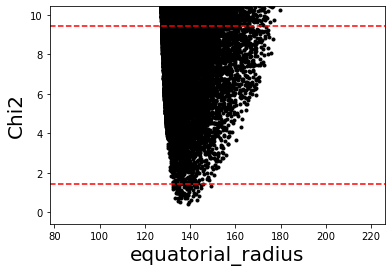

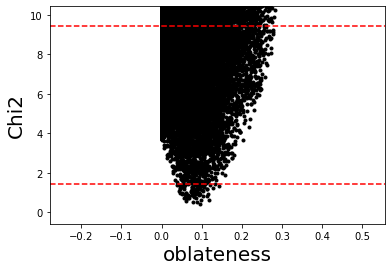

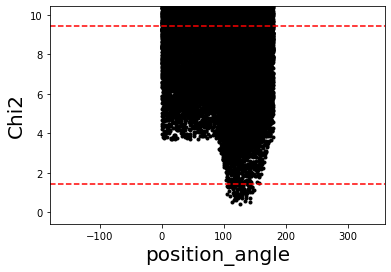

In [32]:
ellipse_chi2.plot_chi2()

**Now, besides the chords we can plot the fitted ellipse**

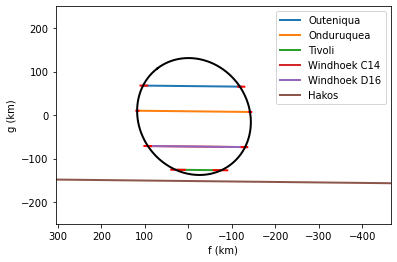

In [33]:
from sora.extra import draw_ellipse

occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**ellipse_chi2.get_values())

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**Not just the fitted ellipse, but the user can also plot all the ellipses inside an sigma region, for instance within $3\sigma$**

This step will, possible, plot large number of ellipses, this can spend some CPU time.

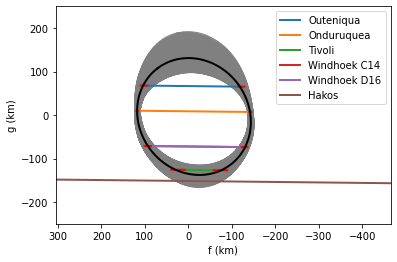

In [34]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**ellipse_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**ellipse_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

**As can be seen, there are some ellipses that cross the Hakos negative chord. They are impossible solutions as the Hakos lightcurve show no evidence of an occultation. The User can filter this solutions using the** `filter_negative_chord()` **function.**

In [35]:
from sora.occultation import filter_negative_chord

In [36]:
filter_negative_chord?

Signature: filter_negative_chord(chord, chisquare, step=1, sigma=0)
Docstring:
Get points for the ellipse with the given input parameters.

Parameters
----------
chord : `sora.observer.Chord`
    Chord object, must be associated to an Occultation to work.

chisquare : `sora.extra.ChiSquare`
    Resulted ChiSquare object of fit_ellipse.

sigma : `int`, `float`
    Uncertainty of the expected ellipse, in km.

step : `int`, `float`, `str`
    If a number, it corresponds to the step, in seconds, for each point of
    the chord path. The step can also be equal to ``'exposure'``. In this
    case, the chord path will consider the lightcurve individual times and
    exptime.
File:      ~/anaconda3/lib/python3.8/site-packages/sora/occultation/utils.py
Type:      function


In [37]:
filter_chi2 = filter_negative_chord(chord=occ.chords['Hakos'], chisquare=ellipse_chi2, step=0.5)

print(filter_chi2)

Filter chord: Hakos |████████████████████████████████████████|  - 100% 
Minimum chi-square: 0.427
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.085

center_f:
    1-sigma: -13.506 +/- 1.250
    3-sigma: -13.516 +/- 4.409

center_g:
    1-sigma: -1.515 +/- 5.842
    3-sigma: 0.322 +/- 17.131

equatorial_radius:
    1-sigma: 140.809 +/- 8.256
    3-sigma: 148.322 +/- 20.981

oblateness:
    1-sigma: 0.091 +/- 0.053
    3-sigma: 0.126 +/- 0.126

position_angle:
    1-sigma: 127.154 +/- 21.627
    3-sigma: 90.005 +/- 89.993



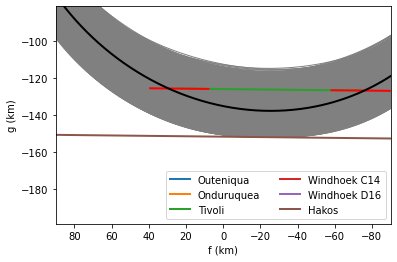

In [38]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**filter_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**filter_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=4,ncol=2)
pl.xlim(+90,-90)
pl.ylim(-180,-100)
pl.show()

**The user can set** `step = "exposure"` **and consider only the region where data was acquired, allowing ellipses that crosses the negative chord during its readout time.**

In [39]:
filter_2_chi2 = filter_negative_chord(chord = occ.chords['Hakos'], chisquare = ellipse_chi2, step='exposure')

print(filter_2_chi2)

Filter chord: Hakos |████████████████████████████████████████|  - 100% 
Minimum chi-square: 0.427
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.085

center_f:
    1-sigma: -13.506 +/- 1.250
    3-sigma: -13.516 +/- 4.409

center_g:
    1-sigma: -1.515 +/- 5.842
    3-sigma: 0.322 +/- 17.131

equatorial_radius:
    1-sigma: 140.809 +/- 8.256
    3-sigma: 148.910 +/- 21.569

oblateness:
    1-sigma: 0.091 +/- 0.053
    3-sigma: 0.128 +/- 0.128

position_angle:
    1-sigma: 127.154 +/- 21.627
    3-sigma: 90.005 +/- 89.993



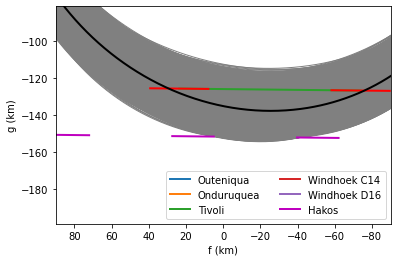

In [40]:
occ.chords.plot_chords(segment='positive')
occ.chords.plot_chords(segment='error', color='red')

chord2.plot_chord(segment='negative', linestyle='exposure', color='m', label='Hakos')

#plotting the best fitted ellipse, in black
draw_ellipse(**filter_2_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**filter_2_chi2.get_values(sigma=3),alpha=1.0,lw=1)

pl.legend(loc=4,ncol=2)
pl.xlim(+90,-90)
pl.ylim(-180,-100)
pl.show()

**The radial velocity issue**

During the `LightCurve` fitting, the user has to add the velocity for that light curve. In the initial process, only the geocentric velocity was determined, and only after the fit, a radial velocity can be correctly calculated.

Usually, the light curves' features are dominated by the exposure time. However, in the cases that the fresnel diffraction plays a significant role in it, we suggest that the `LightCurve` fitting procedure should be redone with the correct velocities.

In [41]:
occ.check_velocities()

Outeniqua - Velocity used: 22.004
    Immersion Radial Velocity: 18.886
    Emersion Radial Velocity: 19.306
Onduruquea - Velocity used: 22.004
    Immersion Radial Velocity: 22.285
    Emersion Radial Velocity: 22.287
Tivoli - Velocity used: 22.004
    Immersion Radial Velocity: 9.924
    Emersion Radial Velocity: 6.162
Windhoek C14 - Velocity used: 22.004
    Immersion Radial Velocity: 19.140
    Emersion Radial Velocity: 18.543
Windhoek D16 - Velocity used: 22.004
    Immersion Radial Velocity: 19.087
    Emersion Radial Velocity: 18.591


<a id="section_4"></a>

## 4. Viewing and saving the results

In the end, we can see the results using Python dictionaries. The `Occultation.fitted_params` will have fitted parameters and their $1\sigma$ uncertainties. The `Occultation.chi2_params` will have some information about the fit and its quality.



In [42]:
occ.fitted_params

{'equatorial_radius': [140.80911198738357, 8.256211776665637],
 'center_f': [-13.50554931562, 1.249787232745648],
 'center_g': [-1.5154075413571029, 5.8417275540201485],
 'oblateness': [0.09050553907776902, 0.0526394910762792],
 'position_angle': [127.15394835773971, 21.627039521298187]}

In [43]:
occ.chi2_params

{'chord_name': ['Outeniqua_immersion',
  'Outeniqua_emersion',
  'Onduruquea_immersion',
  'Onduruquea_emersion',
  'Tivoli_immersion',
  'Tivoli_emersion',
  'Windhoek C14_immersion',
  'Windhoek C14_emersion',
  'Windhoek D16_immersion',
  'Windhoek D16_emersion'],
 'radial_dispersion': array([-1.03006949, -3.8847936 , -2.2537106 , -2.3288812 , -1.14156144,
        -2.45292796, -1.85591233, -1.30904949, -2.9314033 , -0.59071256]),
 'position_angle': array([301.73450933,  59.08621439, 273.84163395,  84.95610277,
        205.74097745, 163.39122869, 238.27098204, 123.33578237,
        238.0083086 , 123.11699625]),
 'radial_error': array([ 7.15443574,  7.60165513,  2.23532231,  2.45888162, 15.65001123,
        15.65007495,  5.36529322,  5.81243008,  6.25950439,  7.60088697]),
 'chi2_min': 0.42675533148650285,
 'nparam': 5,
 'npts': 10}

**The astrometrical positions obtained can be seen using** `Occultation.new_astrometric_position()`

In [44]:
occ.new_astrometric_position()

Ephemeris offset (km): X = -13.5 km +/- 1.2 km; Y = -1.5 km +/- 5.8 km
Ephemeris offset (mas): da_cos_dec = -1.270 +/- 0.118; d_dec = -0.143 +/- 0.549

Astrometric object position at time 2017-06-22 21:18:48.200 for reference 'geocenter'
RA = 18 55 15.6523919 +/- 0.124 mas; DEC = -31 31 21.622040 +/- 0.550 mas


**If the user wants the position at a specific time**

In [45]:
occ.new_astrometric_position('2017-06-22 21:21:00.000')

Ephemeris offset (km): X = -13.5 km +/- 1.2 km; Y = -1.5 km +/- 5.8 km
Ephemeris offset (mas): da_cos_dec = -1.270 +/- 0.118; d_dec = -0.143 +/- 0.549

Astrometric object position at time 2017-06-22 21:21:00.000 for reference 'geocenter'
RA = 18 55 15.6310590 +/- 0.124 mas; DEC = -31 31 21.623435 +/- 0.550 mas


**Also a 'post-fit' occultation map can be created using** `Occultation.plot_occ_map()`

The function that plots the map contains a large number of _kwargs_. They can be used to completely control the map and its tutorial can be found at SORA documentation <a href=https://sora.readthedocs.io/>here</a>.   

In [46]:
occ.plot_occ_map(centermap_delta=[-3500,+400],zoom=20,nameimg='output/map_posfit')

Projected shadow radius = 136.2 km
output/map_posfit.png generated


<img src='output/map_posfit.png' style='width:600px;height:500px'/>

**All this information can also be seen using** `print(Occultation)`

In [47]:
print(occ)

Stellar occultation of star Gaia-EDR3 6760223758801661440 by 10199 Chariklo (1997 CU26).

Geocentric Closest Approach: 0.049 arcsec
Instant of CA: 2017-06-22 21:18:48.200
Position Angle: 359.72 deg
Geocentric shadow velocity: 22.00 km / s
Sun-Geocenter-Target angle:  166.42 deg
Moon-Geocenter-Target angle: 149.11 deg


5 positive observations
1 negative observations

###############################################################################
                                     STAR                                      
###############################################################################
Gaia-EDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=0.00 +/- 0.00 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H: 11.781,
            K: 11.627

Apparent diameter from 

**And this can be saved to an ASCII file using** `Occultation.to_log`

In [48]:
occ.to_log('output/Test_occ.log')

!ls output/*.log

output/Test_occ.log


**This Jupyter-Notebook was designed as a tutorial for how to work with the** `Occultation` **Class. More information about the other classes, please refer to their specif Jupyter-Notebook. Any further question, please contact the core team: Altair Ramos Gomes Júnior, Bruno Eduardo Morgado, Gustavo Benedetti Rossi, and Rodrigo Carlos Boufleur.**

**The End**